## Figure 5 - JUMP application

We attempt to integrate the JUMP dataset in with MitoCheck.
We quickly realize this is a super challenging task, and determine strategies to overcome challenges.

- Panel A: JUMP + MitoCheck UMAP
- Panel B: JUMP + MitoCheck UMAP with only AreaShape features
- Panel C: Comparison between cell lines and time for phenotype enrichment

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))

# Load variables important for plotting (e.g., themes, phenotypes, etc.)
source("themes.r")

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘patchwork’ was built under R version 4.2.3”


In [2]:
# Set output file paths
output_folder <- "figures"

jump_phenotype_enrichment_supplementary_file <- file.path(output_folder, "supplementary", "supplementary_jump_enrichment_shuffled_and_extended.png")
output_fig_5_file <- file.path(output_folder, "main_figure_5_jump_application.png")

In [3]:
# Set paths to load UMAP coordinates
# Loaded from: https://github.com/WayScience/JUMP-single-cell/tree/main/3.analyze_data/UMAP_analysis/results/Mito_JUMP_areashape_features
repo <- "https://github.com/WayScience/JUMP-single-cell"
commit_hash <- "d95bcc99cb99fe9093bf0d73e2019edeb1e57e87"
umap_file_path <- "3.analyze_data/UMAP_analysis/results/"

all_feature_umap_file <- "Mito_JUMP_all_features/Mito_JUMP_all_features_final_greg_areashape_model.tsv"
area_shape_umap_file <- "Mito_JUMP_areashape_features/Mito_JUMP_areashape_features_final_all_features_model.tsv"

all_feature_umap <- paste(repo, "raw", commit_hash, umap_file_path, all_feature_umap_file, sep = "/")
area_shape_umap <- paste(repo, "raw", commit_hash, umap_file_path, area_shape_umap_file, sep = "/")

In [4]:
# Load UMAP coordinates
all_feature_umap_df <- readr::read_tsv(
    all_feature_umap,
    col_types = readr::cols(
        .default = "d",
        Metadata_data_name = "c",
        Metadata_Predicted_Class = "c"
    )
)

area_shape_umap_df <- readr::read_tsv(
    area_shape_umap,
    col_types = readr::cols(
        .default = "d",
        Metadata_data_name = "c",
        Metadata_Predicted_Class = "c"
    )
)

print(dim(area_shape_umap_df))
head(area_shape_umap_df)

[1] 53916     5


Metadata_data_name,Metadata_Predicted_Class,Metadata_Phenotypic_Value,UMAP0,UMAP1
<chr>,<chr>,<dbl>,<dbl>,<dbl>
mitocheck,Large,1,1.97279210,6.335934
mitocheck,Large,1,3.21187040,5.616934
mitocheck,Large,1,-0.42430085,8.314137
mitocheck,Large,1,-0.07658324,10.818566
mitocheck,Large,1,2.21196080,6.890884
mitocheck,Large,1,3.82852080,5.996650


## Visualize UMAP coordinate integration JUMP into MitoCheck

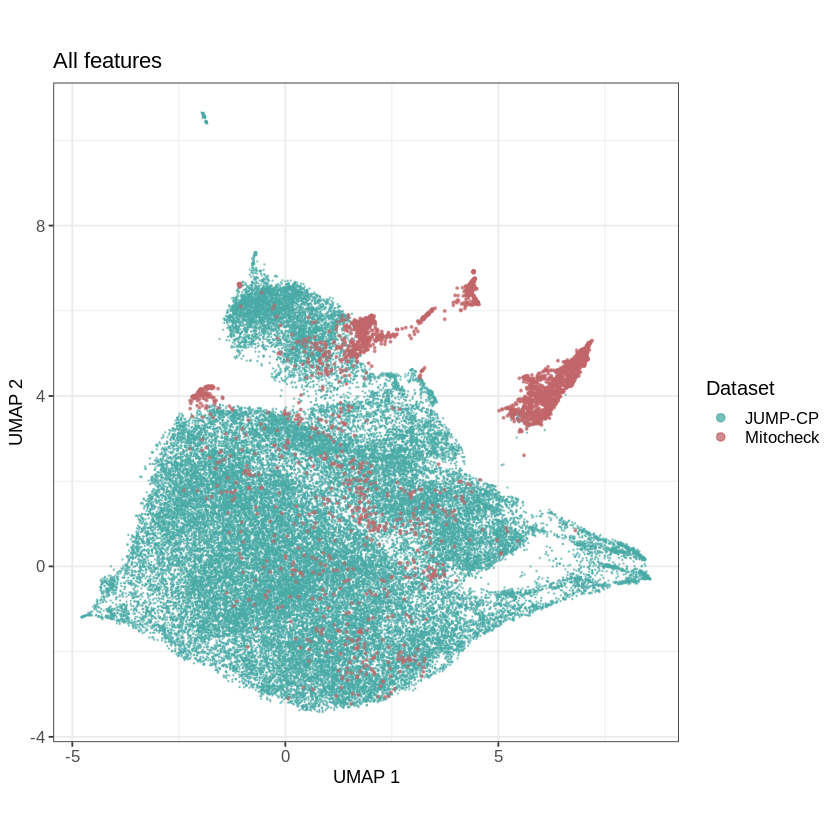

In [5]:
all_feature_umap_gg <- (
    ggplot(all_feature_umap_df, aes(x = UMAP0, y = UMAP1))
    + geom_point(
        aes(color = Metadata_data_name),
        size = 0.1,
        alpha = 0.5
    )
    + geom_point(
        data = all_feature_umap_df %>% dplyr::filter(Metadata_data_name == "mitocheck"),
        aes(color = Metadata_data_name),
        size = 0.5,
        alpha = 0.5
    )
    + theme_bw()
    + phenotypic_ggplot_theme
    + guides(
        color = guide_legend(
            override.aes = list(size = 2)
        )
    )
    + labs(x = "UMAP 1", y = "UMAP 2")
    + scale_color_manual(
        "Dataset",
        values = dataset_colors,
        labels = dataset_labels
    )
    + ggtitle("All features")
    + coord_fixed()
)

all_feature_umap_gg

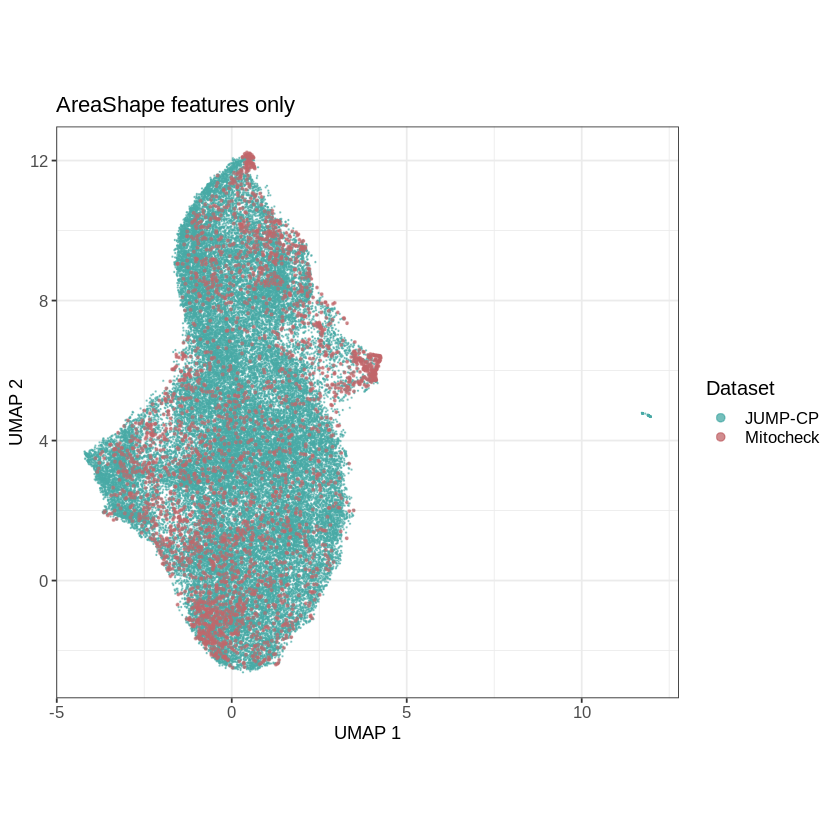

In [6]:
area_shape_umap_gg <- (
    ggplot(area_shape_umap_df, aes(x = UMAP0, y = UMAP1))
    + geom_point(
        aes(color = Metadata_data_name),
        size = 0.07,
        alpha = 0.5
    )
    + geom_point(
        data = area_shape_umap_df %>% dplyr::filter(Metadata_data_name == "mitocheck"),
        aes(color = Metadata_data_name),
        size = 0.5,
        alpha = 0.5
    )
    + theme_bw()
    + phenotypic_ggplot_theme
    + guides(
        color = guide_legend(
            override.aes = list(size = 2)
        )
    )
    + labs(x = "UMAP 1", y = "UMAP 2")
    + scale_color_manual(
        "Dataset",
        values = dataset_colors,
        labels = dataset_labels
    )
    + ggtitle("AreaShape features only")
    + coord_fixed()
) 

area_shape_umap_gg

## Compare JUMP enrichment scores across cell lines and incubation times

In [7]:
# Set file paths
jump_path <- file.path("..", "3.evaluate_model", "jump_phenotype_profiles")

jump_compare_conditions_file <- file.path(jump_path, "jump_compare_cell_types_and_time_across_phenotypes.tsv.gz")
jump_phenotype_umap_file <- file.path(jump_path, "jump_phenotype_profiling_umap.tsv.gz")

In [8]:
#  Load and process data
jump_compare_df <- readr::read_tsv(
    jump_compare_conditions_file,
    show_col_types = FALSE
) %>%
    # Generate new columns that we will use for plotting:
    # 1) Phenotype colors
    # Note, we define focus_phenotypes in themes.r
    dplyr::mutate(phenotype_plot_label = if_else(
        phenotype %in% focus_phenotypes,
        phenotype,
        "Other"
    )) %>%
    # 2) High vs. low incubation time
    dplyr::mutate(time_plot_label = if_else(
        treatment_type == "orf" & Time == 48,
        "Low",
        "tbd"
    )) %>%
    dplyr::mutate(time_plot_label = if_else(
        treatment_type == "orf" & Time == 96,
        "High",
        time_plot_label
    )) %>%
    dplyr::mutate(time_plot_label = if_else(
        treatment_type == "compound" & Time == 24,
        "Low",
        time_plot_label
    )) %>%
    dplyr::mutate(time_plot_label = if_else(
        treatment_type == "compound" & Time == 48,
        "High",
        time_plot_label
    )) %>%
    dplyr::mutate(time_plot_label = if_else(
        treatment_type == "crispr" & Time == 96,
        "Low",
        time_plot_label
    )) %>%
    dplyr::mutate(time_plot_label = if_else(
        treatment_type == "crispr" & Time == 144,
        "High",
        time_plot_label
    )) %>%
    dplyr::mutate(
        neg_log10_pval_A549 = -log10(p_value_A549),
        neg_log10_pval_U2OS = -log10(p_value_U2OS)
    )

jump_compare_df$time_plot_label <-
    factor(jump_compare_df$time_plot_label, levels = c("Low", "High"))

jump_compare_df$phenotype_plot_label <-
    dplyr::recode_factor(jump_compare_df$phenotype_plot_label, !!!focus_phenotype_labels)

print(dim(jump_compare_df))
head(jump_compare_df)

[1] 37320    13


treatment,treatment_type,Time,phenotype,Metadata_model_type,comparison_metric_value_A549,comparison_metric_value_U2OS,p_value_A549,p_value_U2OS,phenotype_plot_label,time_plot_label,neg_log10_pval_A549,neg_log10_pval_U2OS
<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>
1-EBIO,compound,24,ADCCM,final,0.04240057,0.04945870,0.1425088,0.5302497,Other,Low,0.8461583,0.2755196
1-EBIO,compound,24,ADCCM,shuffled,0.02781257,0.04056253,0.5952397,0.5394439,Other,Low,0.2253081,0.2680537
1-EBIO,compound,24,Anaphase,final,0.03623531,0.06436034,0.3430610,0.2850877,Other,Low,0.4646286,0.5450216
1-EBIO,compound,24,Anaphase,shuffled,0.03351298,0.04833727,0.4611384,0.3469117,Other,Low,0.3361687,0.4597811
1-EBIO,compound,24,Apoptosis,final,0.03345717,0.07236376,0.4684678,0.1005099,Apoptosis,Low,0.3293202,0.9977914
1-EBIO,compound,24,Apoptosis,shuffled,0.03974556,0.05759343,0.3462659,0.2332836,Apoptosis,Low,0.4605903,0.6321158


Warning message:
“Removed 30 rows containing missing values (`geom_point()`).”


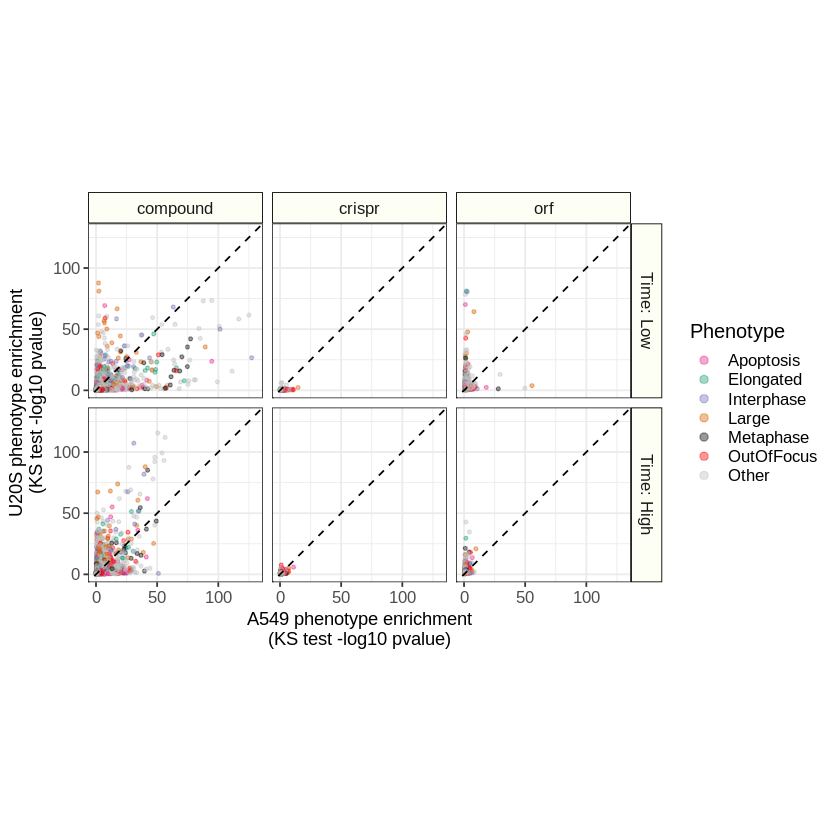

In [9]:
custom_time_labeller <- function(value) {
  paste("Time:", value)
}

compare_phenotype_enrichment_ggs <- list()
for (model_type in c("final", "shuffled")) {
    jump_subset_compare_df <- jump_compare_df %>%
        dplyr::filter(Metadata_model_type == !!model_type)
    
    compare_phenotype_enrichment_ggs[[model_type]] <- (
        ggplot(
            jump_subset_compare_df,
            aes(
                x = neg_log10_pval_A549,
                y = neg_log10_pval_U2OS,
                color = phenotype_plot_label
            )
        )
        + geom_point(
            size = 0.8,
            alpha = 0.4
        )
        + geom_abline(slope = 1, intercept = 0, color = "black", linetype = "dashed")
        + theme_bw()
        + scale_color_manual(
            "Phenotype",
            values = focus_phenotype_colors,
            labels = focus_phenotype_labels
        )
        + phenotypic_ggplot_theme
        + guides(
            color = guide_legend(
                override.aes = list(size = 2)
            )
        )
        + facet_grid(
            "time_plot_label~treatment_type",
            labeller = labeller(time_plot_label = custom_time_labeller)
        )
        + coord_fixed()
        + scale_x_continuous(limits = c(0, 130))
        + scale_y_continuous(limits = c(0, 130))
        + labs(
            x = "A549 phenotype enrichment\n(KS test -log10 pvalue)",
            y = "U20S phenotype enrichment\n(KS test -log10 pvalue)"
        )
    )
}


compare_phenotype_enrichment_ggs[["final"]]

In [10]:
# Load and process phenotype UMAP
jump_phenotype_umap_df <- readr::read_tsv(
    jump_phenotype_umap_file,
    show_col_types = FALSE
) %>%
    # 2) High vs. low incubation time
    dplyr::mutate(time_plot_label = if_else(
        treatment_type == "orf" & Time == 48,
        "Low",
        "tbd"
    )) %>%
    dplyr::mutate(time_plot_label = if_else(
        treatment_type == "orf" & Time == 96,
        "High",
        time_plot_label
    )) %>%
    dplyr::mutate(time_plot_label = if_else(
        treatment_type == "compound" & Time == 24,
        "Low",
        time_plot_label
    )) %>%
    dplyr::mutate(time_plot_label = if_else(
        treatment_type == "compound" & Time == 48,
        "High",
        time_plot_label
    )) %>%
    dplyr::mutate(time_plot_label = if_else(
        treatment_type == "crispr" & Time == 96,
        "Low",
        time_plot_label
    )) %>%
    dplyr::mutate(time_plot_label = if_else(
        treatment_type == "crispr" & Time == 144,
        "High",
        time_plot_label
    ))

jump_phenotype_umap_df$time_plot_label <-
    factor(jump_phenotype_umap_df$time_plot_label, levels = c("Low", "High"))

print(dim(jump_phenotype_umap_df))
head(jump_phenotype_umap_df)

[1] 32358    11


Metadata_Plate,treatment,treatment_type,Cell_type,Time,Metadata_Well,cell_count,UMAP0,UMAP1,model_type,time_plot_label
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
BR00116991,1-EBIO,compound,A549,24,P06,1473,12.305723,6.603716,final,Low
BR00116991,1-octanol,compound,A549,24,I24,1111,9.710662,4.139770,final,Low
BR00116991,"2,5-furandimethanol",compound,A549,24,G12,1153,10.523869,4.440982,final,Low
BR00116991,2-Oleoylglycerol,compound,A549,24,H02,1451,11.066898,4.891216,final,Low
BR00116991,4-CMTB,compound,A549,24,C01,1570,7.409092,5.019341,final,Low
BR00116991,4-methylhistamine,compound,A549,24,N01,1742,10.368308,9.137271,final,Low


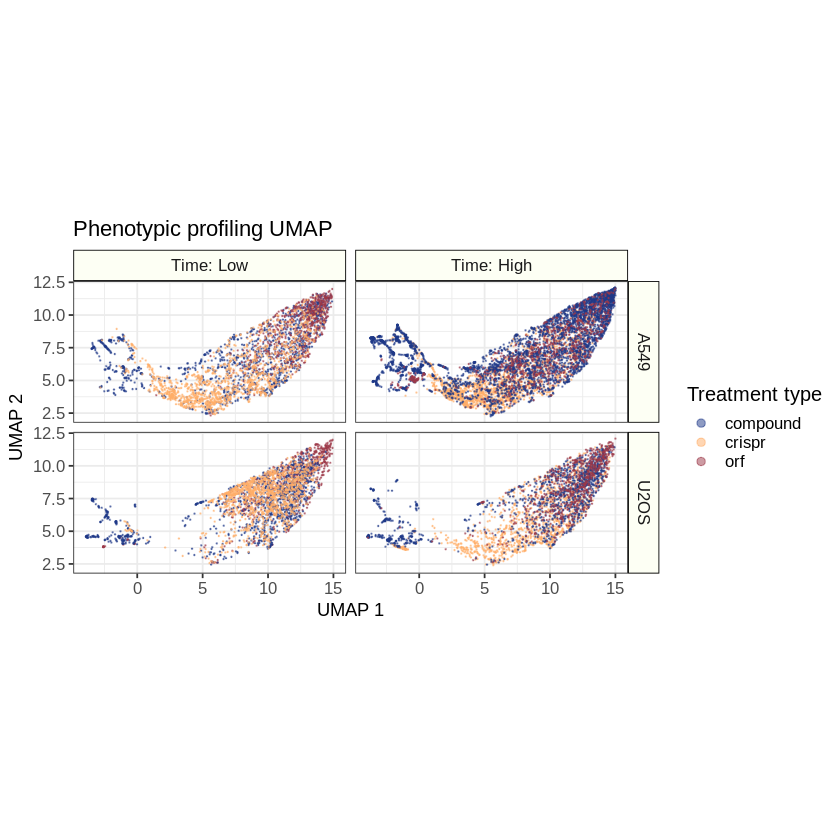

In [11]:
phenotype_umap_gg <- (
    ggplot(jump_phenotype_umap_df %>% dplyr::filter(model_type == "final"), aes(x = UMAP0, y = UMAP1))
    + geom_point(
        aes(color = treatment_type),
        size = 0.07,
        alpha = 0.5
    )
    + theme_bw()
    + phenotypic_ggplot_theme
    + guides(
        color = guide_legend(
            override.aes = list(size = 2)
        )
    )
    + labs(x = "UMAP 1", y = "UMAP 2")
    + scale_color_manual(
        "Treatment type",
        values = treatment_type_colors,
        labels = treatment_type_labels
    )
    + coord_fixed()
    + facet_grid(
        "Cell_type~time_plot_label",
        labeller = labeller(time_plot_label = custom_time_labeller)
    )
    + ggtitle("Phenotypic profiling UMAP")
) 

phenotype_umap_gg

## Compile main figure

In [12]:
top_plot <- (
    all_feature_umap_gg | 
    area_shape_umap_gg
) + plot_layout(guides = "collect")

fig_5_gg <- (
    wrap_elements(top_plot) /
    wrap_elements(compare_phenotype_enrichment_ggs[["final"]]) /
    wrap_elements(phenotype_umap_gg)
) + plot_annotation(tag_levels = "A") + plot_layout(heights = c(1, 1.1, 1))

ggsave(output_fig_5_file, dpi = 500, height = 12, width = 8)

#fig_5_gg

Warning message:
“Removed 30 rows containing missing values (`geom_point()`).”


## Generate supplementary figure

In [13]:
jump_other_phenotype_df <- jump_compare_df %>% 
    dplyr::filter(
        !phenotype %in% focus_phenotypes,
        Metadata_model_type == "final"
    )

head(jump_other_phenotype_df)

treatment,treatment_type,Time,phenotype,Metadata_model_type,comparison_metric_value_A549,comparison_metric_value_U2OS,p_value_A549,p_value_U2OS,phenotype_plot_label,time_plot_label,neg_log10_pval_A549,neg_log10_pval_U2OS
<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>
1-EBIO,compound,24,ADCCM,final,0.04240057,0.04945870,0.1425088,0.5302497,Other,Low,0.8461583,0.2755196
1-EBIO,compound,24,Anaphase,final,0.03623531,0.06436034,0.3430610,0.2850877,Other,Low,0.4646286,0.5450216
1-EBIO,compound,24,Binuclear,final,0.03862297,0.05082301,0.3764450,0.3001864,Other,Low,0.4242985,0.5226090
1-EBIO,compound,24,Grape,final,0.03389026,0.04967801,0.4057712,0.3206900,Other,Low,0.3917188,0.4939145
1-EBIO,compound,24,Hole,final,0.03439329,0.04008213,0.3983961,0.5552837,Other,Low,0.3996849,0.2554851
1-EBIO,compound,24,MetaphaseAlignment,final,0.03279152,0.03681540,0.3970332,0.6333113,Other,Low,0.4011732,0.1983828


In [14]:
# Custom function for name repair
name_repair_function <- function(names) {
  names[4] <- paste0(names[4], "_original")
  return(names)
}

expanded_phenotype_colors_time_ggs <- list()
focus_phenotype_colors_time_ggs <- list()

for (time_point in c("Low", "High")) {
    # Focus other phenotypes to specific time points
    jump_other_phenotype_per_time_df <- jump_other_phenotype_df %>%
        dplyr::filter(time_plot_label == !!time_point)

    # Create a background data for plotting gray points
    df_background <- tidyr::crossing(
        jump_other_phenotype_per_time_df,
        phenotype = unique(jump_other_phenotype_per_time_df$phenotype),
        .name_repair = name_repair_function
    )

    # Create the figure for other phenotypes
    jump_sup_fig_other_gg <- (
        ggplot(
            jump_other_phenotype_per_time_df,
            aes(x = neg_log10_pval_A549, y = neg_log10_pval_U2OS)
        )
        + geom_point(
            data = df_background,
            color = "lightgray",
            size = 0.8,
            alpha = 0.6
        )
        + geom_point(
            aes(color = phenotype),
            size = 0.8
        )
        + geom_abline(slope = 1, intercept = 0, color = "black", linetype = "dashed")
        + facet_grid("treatment_type~phenotype")
        + theme_bw()
        + phenotypic_ggplot_theme
        + guides(
            color = guide_legend(
                override.aes = list(size = 2)
            )
        )
        + labs(
            x = "A549 phenotype enrichment\n(KS test -log10 pvalue)",
            y = "U20S phenotype enrichment\n(KS test -log10 pvalue)"
        )
        + theme(
            legend.position = "none",
            strip.text = element_text(size = 8),
        )
    )

    # Save in gg list
    expanded_phenotype_colors_time_ggs[[time_point]] <- jump_sup_fig_other_gg

    # Now switch to the focus phenotypes
    jump_focus_phenotype_per_time_df <- jump_compare_df %>% 
        dplyr::filter(
            phenotype %in% focus_phenotypes,
            Metadata_model_type == "final",
            time_plot_label == !!time_point
        )

    df_background <- tidyr::crossing(
        jump_focus_phenotype_per_time_df,
        phenotype = unique(jump_focus_phenotype_per_time_df$phenotype),
        .name_repair = name_repair_function
    )
    
    # Create the figure for focus phenotypes
    jump_sup_fig_focus_gg <- (
        ggplot(
            jump_focus_phenotype_per_time_df,
            aes(x = neg_log10_pval_A549, y = neg_log10_pval_U2OS)
        )
        + geom_point(
            data = df_background,
            color = "lightgray",
            size = 0.8,
            alpha = 0.6
        )
        + geom_point(
            aes(color = phenotype),
            size = 0.8
        )
        + geom_abline(slope = 1, intercept = 0, color = "black", linetype = "dashed")
        + facet_grid("treatment_type~phenotype")
        + theme_bw()
        + phenotypic_ggplot_theme
        + guides(
            color = guide_legend(
                override.aes = list(size = 2)
            )
        )
        + scale_color_manual(
            "Phenotype",
            values = focus_phenotype_colors,
            labels = focus_phenotype_labels
        )
        + labs(
            x = "A549 phenotype enrichment\n(KS test -log10 pvalue)",
            y = "U20S phenotype enrichment\n(KS test -log10 pvalue)"
        )
        + theme(
            legend.position = "none",
            strip.text = element_text(size = 8.5),
        )
    )

    # Save in gg list
    focus_phenotype_colors_time_ggs[[time_point]] <- jump_sup_fig_focus_gg
}

In [15]:
## Save supplementary figure for shuffled p values

nested_plot <- (
    focus_phenotype_colors_time_ggs[["High"]] | plot_spacer()
) + plot_layout(widths = c(3, 1.35))

jump_kstest_full_high_fig <- (
    nested_plot / expanded_phenotype_colors_time_ggs[["High"]]
) + plot_layout(heights = c(1, 1))

nested_low_plot <- (
    focus_phenotype_colors_time_ggs[["Low"]] | plot_spacer()
) + plot_layout(widths = c(3, 1.35))

jump_kstest_full_low_fig <- (
    nested_low_plot / expanded_phenotype_colors_time_ggs[["Low"]]
) + plot_layout(heights = c(1, 1))


jump_phenotype_enrichment_supplementary_gg <- (
    wrap_elements(compare_phenotype_enrichment_ggs[["shuffled"]]) /
    jump_kstest_full_low_fig /
    jump_kstest_full_high_fig
    ) + plot_layout(nrow = 3, heights = c(0.5, 1, 1)) + plot_annotation(tag_levels = list(c("A", "B", "", "C", "")))

ggsave(jump_phenotype_enrichment_supplementary_file, dpi = 500, height = 16, width = 11)

Warning message:
“Removed 30 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 36 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 6 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 81 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 9 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 36 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 6 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 81 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 9 rows containing missing values (`geom_point()`).”
